# Group 14 - Project FP01
## Time series anomaly detection

This project aims at investigating the current state-of-the-arts TAD scenario.

In [1]:
import os
import time
import tsfel
import warnings
import datetime
import keras_tuner
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.cm as cm
from sklearn import metrics
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn import preprocessing
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import VarianceThreshold


import dataset as ds

In [2]:
# Path to the root directory of the dataset
ROOTDIR_DATASET_NORMAL = './dataset/normal/'
ROOTDIR_DATASET_COLLISION = './dataset/collisions/'

In [3]:
# TF_ENABLE_ONEDNN_OPTS=0 means that the model will not use the oneDNN library for optimization

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

### Dataset: Kuka-v1
In 5 different recording sessions, the robot executes several different operations, while being
monitored by several sensors. The sensed signals are collected, with different sampling frequencies
(1, 10, 100, 200 Hz),

In [4]:
# Dataset frequency
freq_01s = '0.1'
freq_001s = '0.01'
freq_0005s = '0.005'

### Data Loading

In [5]:
df_action, df, df_meta, action2int = ds.load_data(ROOTDIR_DATASET_NORMAL, freq_01s)

Loading data.
Found 31 different actions.
Loading data done.



In [34]:
df_action, df, df_meta, action2int

(                         machine_nameKuka Robot_apparent_power  \
 time                                                             
 2022-08-11 13:09:50.319                             165.617218   
 2022-08-11 13:09:50.419                             165.617218   
 2022-08-11 13:09:50.519                             165.617218   
 2022-08-11 13:09:50.619                             165.617218   
 2022-08-11 13:09:50.719                             165.617218   
 ...                                                        ...   
 2022-08-11 16:30:05.637                             215.164246   
 2022-08-11 16:30:05.737                             215.164246   
 2022-08-11 16:30:05.837                             215.164246   
 2022-08-11 16:30:05.937                             215.164246   
 2022-08-11 16:30:06.037                             215.164246   
 
                          machine_nameKuka Robot_current  \
 time                                                      
 2022-0

### Feature Extraction
In this section the feature from the dataset is extracted, then the train and test data is split.

In [6]:
X_train, y_train, X_test, y_test = ds.get_train_test_data_df(df_action=df_action, df_meta=df_meta, action2int=action2int)

Computing features.


Skipped feature extraction for pickFromPallet(1,2)=[true,1,0] 2022-08-11 14:37:37.436000 : 2022-08-11 14:37:37.421000.
Skipped feature extraction for placeToPallet(1,1)=[true,0] 2022-08-11 14:37:37.421000 : 2022-08-11 14:37:37.442000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.568000 : 2022-08-11 15:36:32.533000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.572000 : 2022-08-11 15:36:32.561000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.533000 : 2022-08-11 15:36:32.572000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.561000 : 2022-08-11 15:36:32.561000.
Computing features done.
--- 84.46507358551025 seconds ---


In [7]:
# Normalise features
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)

# Remove zero-variance features
selector_variance = VarianceThreshold()
selector_variance.fit(X_train)
X_train = pd.DataFrame(selector_variance.transform(X_train),
                        columns=X_train.columns.values[selector_variance.get_support()])

# Remove highly correlated features
corr_features = tsfel.correlated_features(X_train,
                                          threshold=0.95)
X_train.drop(corr_features, inplace=True, axis=1)

# Lasso selector
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_train, y_train)
lasso = SelectFromModel(lsvc, prefit=True)
selected_features = X_train.columns.values[lasso.get_support()]
X_train = X_train[selected_features].copy()

# Labels
num_classes = len(set(y_train))
y_train_categorical = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)

# Test
X_test = pd.DataFrame(selector_variance.transform(scaler.transform(X_test)),
                      columns=X_test.columns.values[selector_variance.get_support()])
X_test.drop(corr_features, inplace=True, axis=1)
X_test = X_test[selected_features].copy()

In [8]:
from graph import seaborn_cm

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def create_and_plot_cm (y_pred, y_true):
    cm = confusion_matrix(y_true, y_pred.argmax(axis=1), labels=list(action2int.values()))
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    int2action = {v: k for k, v in action2int.items()}
    seaborn_cm(cm,
                ax,
                [int2action[l] for l in action2int.values()], fontsize=8, xrotation=90)
    plt.tight_layout()

In [9]:
input_shape = (X_train.values.shape[1],)
num_classes = len(y_train_categorical[0])

### Bayesian MLP for Anomaly Detection from Lab 7

In [10]:
import bayesian_model
import importlib
importlib.reload(bayesian_model)
from bayesian_model import BayesianMLPClassifier

clf = BayesianMLPClassifier(input_shape, num_classes)
clf.setup_tuner()

clf.search(X_train.values, y_train_categorical)
y_test_pred = clf.predict(X_test.values)

Trial 90 Complete [00h 00m 02s]
accuracy: 0.08779149502515793

Best accuracy So Far: 0.9314128756523132
Total elapsed time: 00h 02m 08s
8/8 [==============================] - 0s 1ms/step


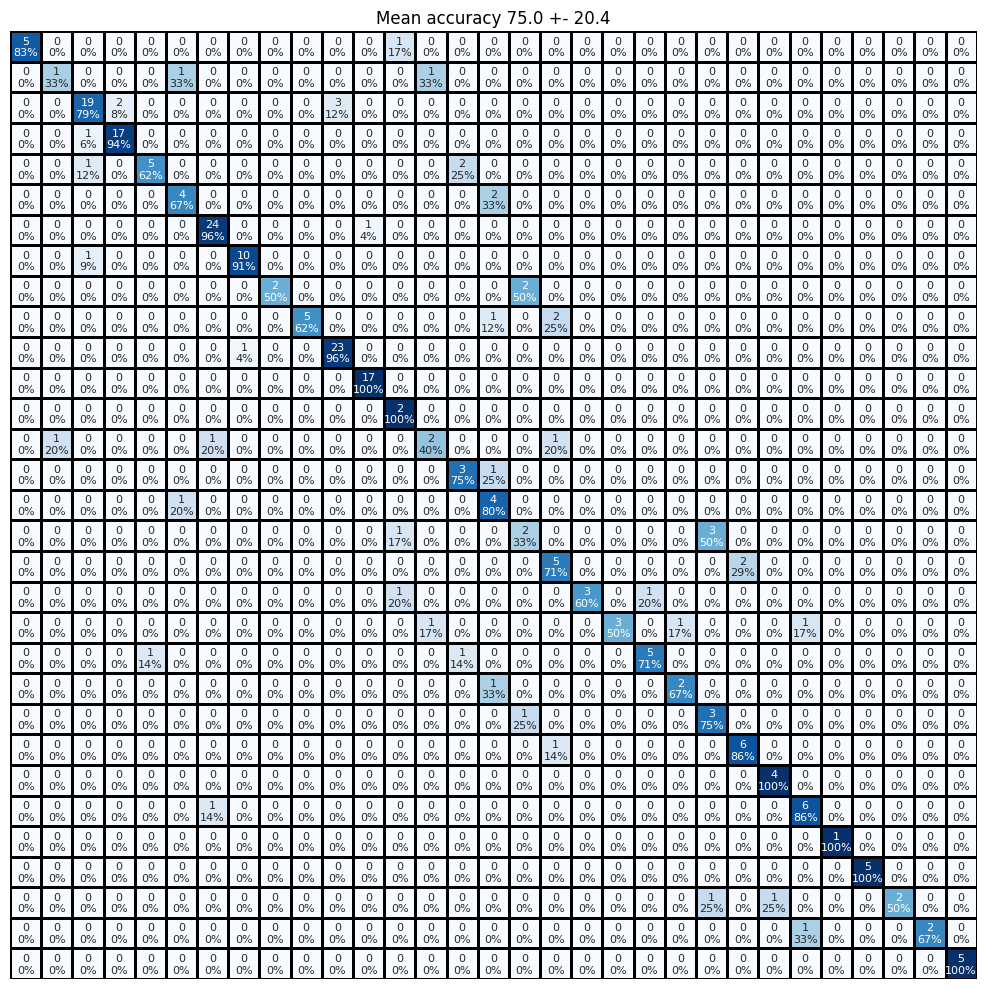

In [11]:
create_and_plot_cm(y_test_pred, y_test)

In [12]:
class Confidence:

    def __init__(self, multiple_preds):
        self.multiple_preds = multiple_preds
        self._uncertainty_metrics = dict()
        self._uncertainty_metrics['entropy'] = self._entropy
        self._uncertainty_metrics['variance'] = self._variance
        self._uncertainty_metrics['max_softmax_response'] = self._max_softmax_response

    def compute_uncertainty_metrics(self):
        return {metric: self._compute_uncertainty(
            metric,
            self.multiple_preds) for metric in self._uncertainty_metrics.keys()}

    def _normalize(self, values):
            return (values - values.min())/(values.max()-values.min())

    def _compute_uncertainty(self, metric, multiple_preds):
        try:
            print("Done {}".format(metric))
            return self._normalize(
                self._uncertainty_metrics[metric](multiple_preds))
        except KeyError:
            print("{} not implemented.".format(metric))

    def _avreage_prediction(self, multiple_preds):
        if len(multiple_preds.shape) > 2:
            return np.mean(np.array(multiple_preds), axis=0)
        else:
            return multiple_preds

    def _entropy(self, multiple_preds):
        avg_preds = self._avreage_prediction(multiple_preds)
        eps = 1e-5
        entropy = -1 * np.sum(avg_preds * np.log(avg_preds + eps), axis=1)
        return entropy

    def _variance(self, multiple_preds):
        avg_preds = self._avreage_prediction(multiple_preds)
        return  np.var(avg_preds, axis=1)

    def _max_softmax_response(self, multiple_preds):
        avg_preds = self._avreage_prediction(multiple_preds)
        return np.max(avg_preds, axis=1)

def anomaly_detection_metric(anomaly_start_timestamps, confidence, df_dataset, thresholds, less_than=True):
    "Actual is y axis"
    if not less_than:
        confidence = 1 - confidence

    sens = list()
    spec = list()
    fpr = list()
    f1 = list()
    prec = list()
    cm_list = list()
    anomaly_indexes_dict = dict()
    acc_with_err = list()
    for threshold in thresholds:
        df_not_confident = df_dataset[confidence <= threshold]
        tp = 0
        anomaly_indexes = list()
        for anomaly in anomaly_start_timestamps:
            for index, row in df_not_confident.iterrows():
                if anomaly >= row['start'] and anomaly <= row['end']:
                    anomaly_indexes.append(index)
                    tp += 1

        cm_anomaly = np.zeros((2, 2))
        n_samples = len(df_dataset)
        n_not_collisions = n_samples - len(anomaly_start_timestamps)
        n_detected = len(df_not_confident)

        fp = n_detected - tp
        fn = len(anomaly_start_timestamps) - tp
        tn = n_not_collisions - fp

        cm_anomaly[0][0] = tn
        cm_anomaly[1][1] = tp
        cm_anomaly[0][1] = fp
        cm_anomaly[1][0] = fn
        cm_list.append(cm_anomaly)
        sens.append(tp / (tp + fn))
        recall = tp / (tp + fn)
        prec.append(tp / (tp + fp))
        spec.append(tn / (fp + tn))
        fpr.append(1 - tn / (fp + tn))
        try:
            f1.append(2 * tp / (2 * tp + fp + fn) )
        except ZeroDivisionError:
            f1.append(0)
        cm_anomaly_norm = cm_anomaly.astype('float') / cm_anomaly.sum(axis=1)[:, np.newaxis]
        acc_with_err.append((np.mean(np.diag(cm_anomaly_norm)),
                            np.std(np.diag(cm_anomaly_norm))))


        anomaly_indexes_dict[threshold] = anomaly_indexes
    return sens, spec, fpr, f1, cm_list, anomaly_indexes_dict, acc_with_err, prec

In [13]:
n_mc = 10
preds_array = np.array([y_test_pred])
preds_bayes_mean = np.mean(preds_array, axis=0)

In [14]:
uncertainties_bayes = dict()
uncertainties_bayes["correct"] = Confidence(preds_array.mean(axis=0)[(preds_bayes_mean.argmax(axis=1) == y_test), :]).compute_uncertainty_metrics()
uncertainties_bayes["wrong"] = Confidence(preds_array.mean(axis=0)[(preds_bayes_mean.argmax(axis=1) != y_test), :]).compute_uncertainty_metrics()
uncertainties_bayes["all"] = Confidence(preds_array.mean(axis=0)).compute_uncertainty_metrics()

Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response


In [15]:
# Set style for matplotlib
plt.style.use("Solarize_Light2")

In [16]:
def plot_uncertainty(uncertainties, title):
    fig, axes = plt.subplots(len(uncertainties['correct'].keys()), 3, figsize=(15, 9))
    for ax, measure in zip(axes, uncertainties['correct'].keys()):
        ax[0].set_title(f"Wrong - {measure}")
        ax[0].hist(uncertainties['wrong'][measure], color="red", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5);
        ax[1].set_title(f"Correct - {measure}")
        ax[1].hist(uncertainties['correct'][measure], color="green", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5);
        ax[2].set_title(f"All - {measure}")
        ax[2].hist(uncertainties['all'][measure], color="blue", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5);
    fig.suptitle(title, fontsize=20)
    plt.tight_layout()
    plt.show()

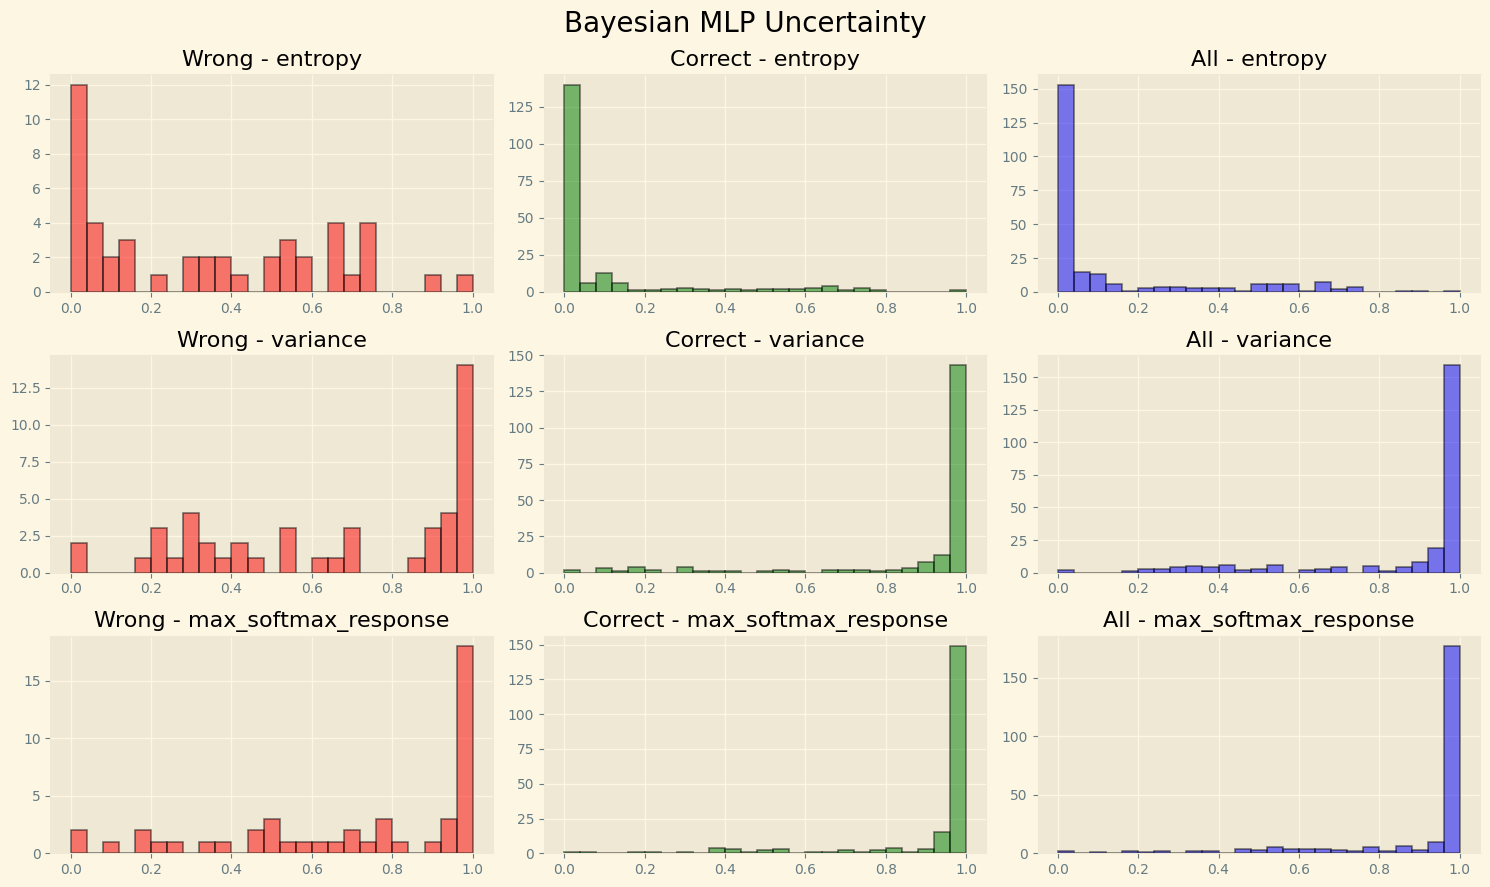

In [17]:
plot_uncertainty(uncertainties_bayes, "Bayesian MLP Uncertainty")

In [18]:
from cnn_model import CNNClassifier

clf = CNNClassifier(input_shape, num_classes)
clf.setup_tuner()

clf.search(X_train.values, y_train_categorical)
y_test_pred = clf.predict(X_test.values)

Trial 90 Complete [00h 00m 06s]
accuracy: 1.0

Best accuracy So Far: 1.0
Total elapsed time: 00h 03m 45s
8/8 [==============================] - 0s 1ms/step


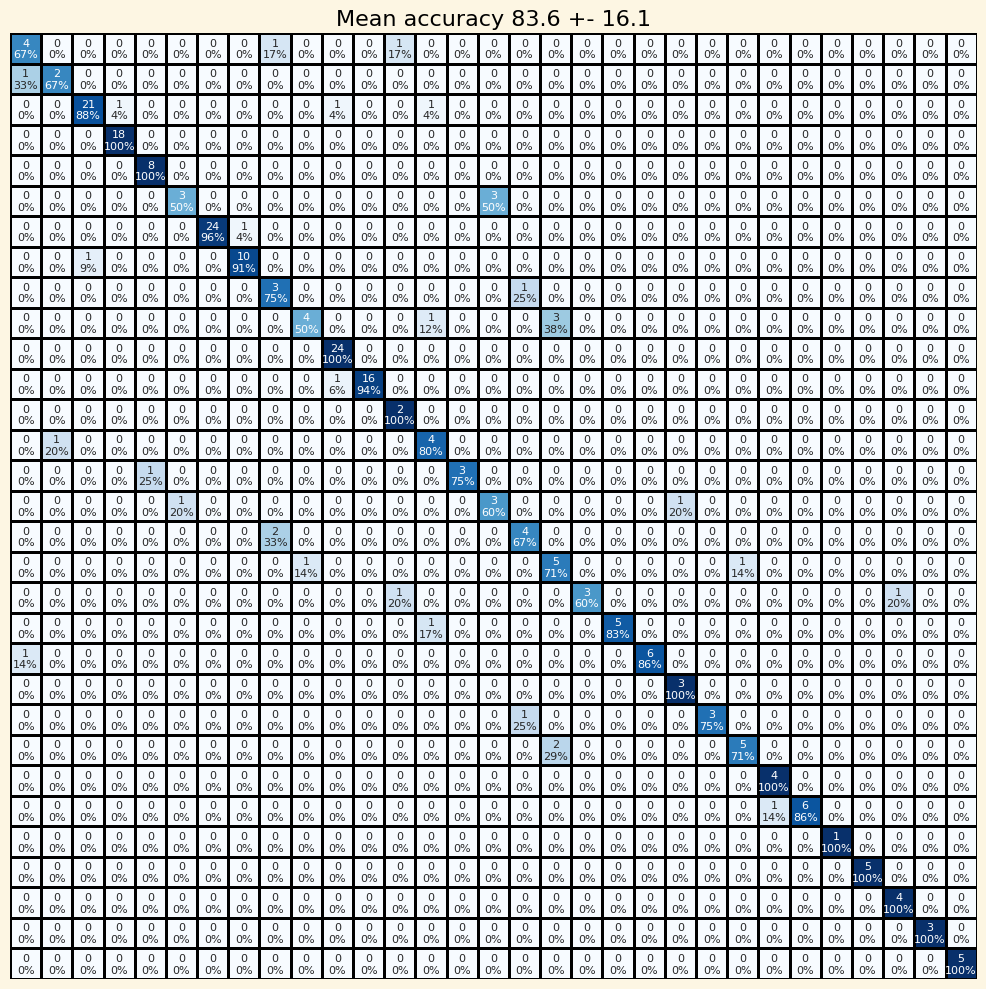

In [19]:
create_and_plot_cm(y_test_pred, y_test)

In [20]:
n_mc = 10
preds_array = np.array([y_test_pred])
preds_bayes_mean = np.mean(preds_array, axis=0)

In [21]:
uncertainties_bayes = dict()
uncertainties_bayes["correct"] = Confidence(preds_array.mean(axis=0)[(preds_bayes_mean.argmax(axis=1) == y_test), :]).compute_uncertainty_metrics()
uncertainties_bayes["wrong"] = Confidence(preds_array.mean(axis=0)[(preds_bayes_mean.argmax(axis=1) != y_test), :]).compute_uncertainty_metrics()
uncertainties_bayes["all"] = Confidence(preds_array.mean(axis=0)).compute_uncertainty_metrics()

Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response


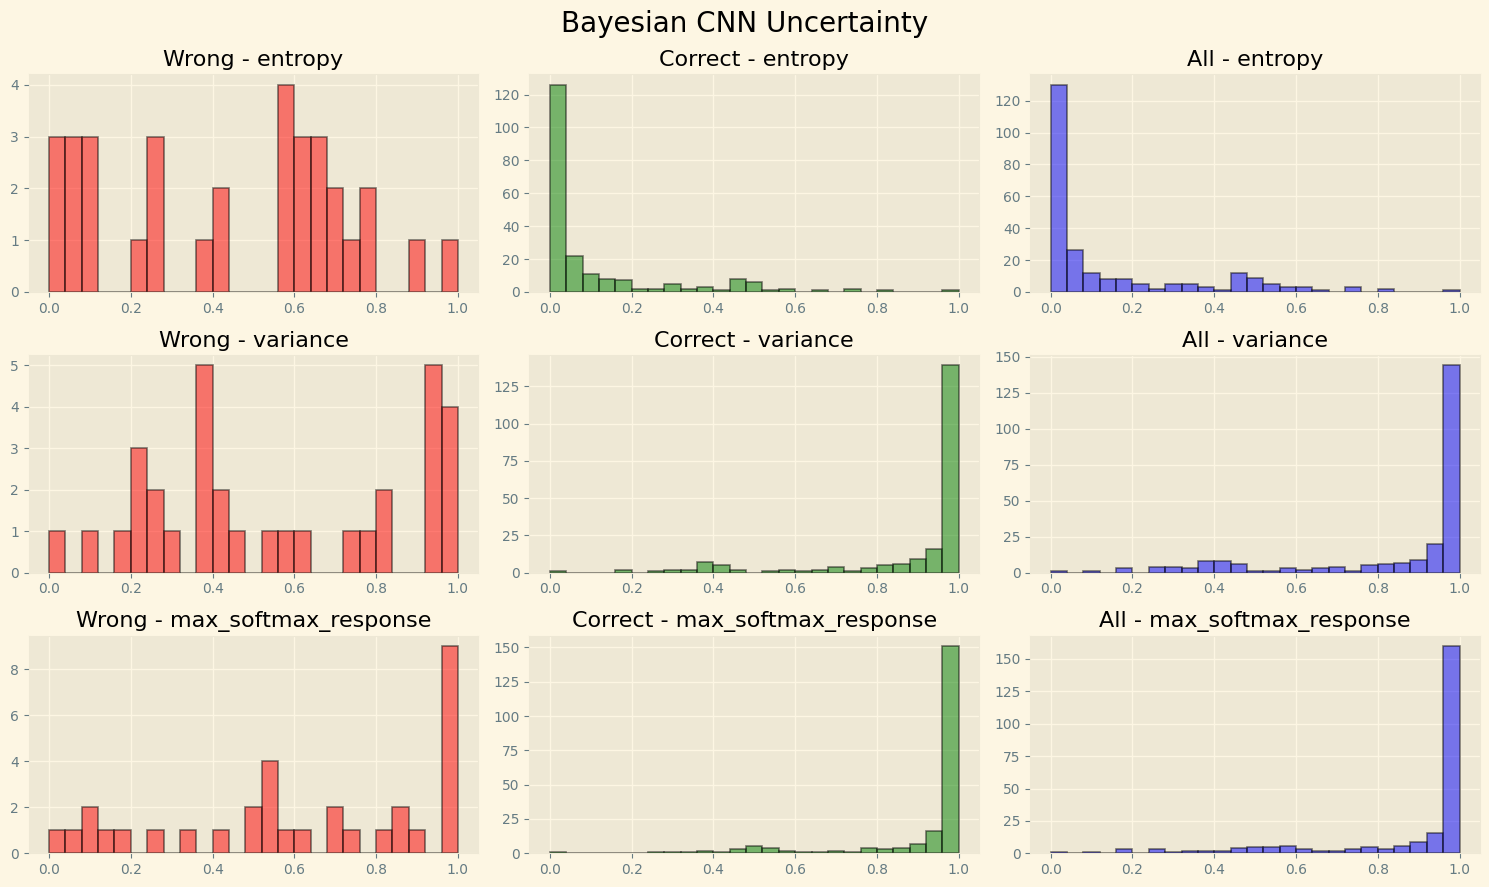

In [22]:
plot_uncertainty(uncertainties_bayes, "Bayesian CNN Uncertainty")

Trial 90 Complete [00h 00m 07s]
val_loss: 0.756072461605072

Best val_loss So Far: 0.6361611485481262
Total elapsed time: 00h 04m 07s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               12160     
                                                                 
 dense_1 (Dense)             (None, 64)                10304     
                                                                 
 dense_2 (Dense)             (None, 160)               10400     
                                                                 
 dense_3 (Dense)             (None, 75)                12075     
                                                                 
Total params: 44939 (175.54 KB)
Trainable params: 44939 (175.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
8/8 [===========

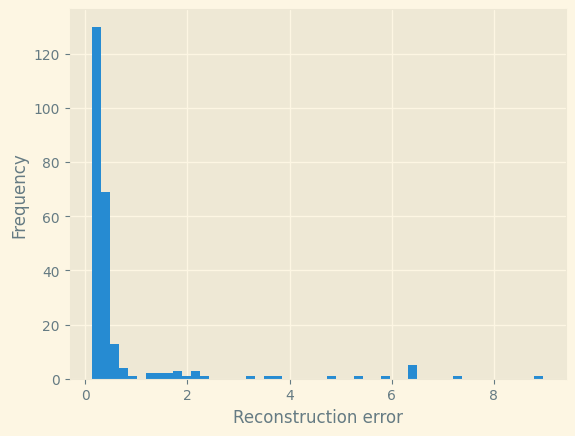

In [35]:
import autoencoders_model
import importlib
importlib.reload(autoencoders_model)

from autoencoders_model import Autoencoder

clf = Autoencoder(input_shape)
clf.setup_tuner()

clf.search(X_train.values)
reconstructed_error = clf.compute_reconstruction_error(X_test.values)

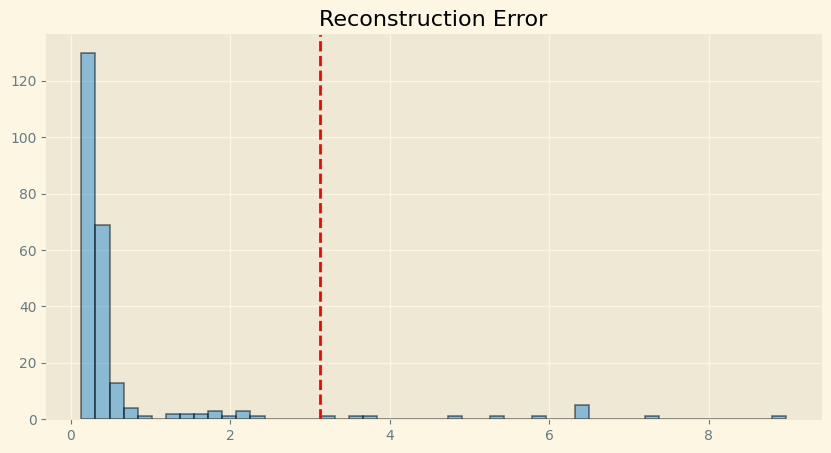

In [37]:
threshold = np.percentile(reconstructed_error, 95)

plt.figure(figsize=(10, 5))
plt.hist(reconstructed_error, bins=50, edgecolor='black', linewidth=1.2, alpha=0.5);
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2)
plt.title("Reconstruction Error")
plt.show()


In [46]:
y_test_binary = (y_test == 0).astype(int)
th = np.percentile(reconstructed_error, 95)

y_pred = (reconstructed_error > th).astype(int)
acc = metrics.accuracy_score(y_test_binary, y_pred)

print(f"Accuracy: {acc}")
    

Accuracy: 0.03278688524590164


8/8 [==============================] - 0s 930us/step


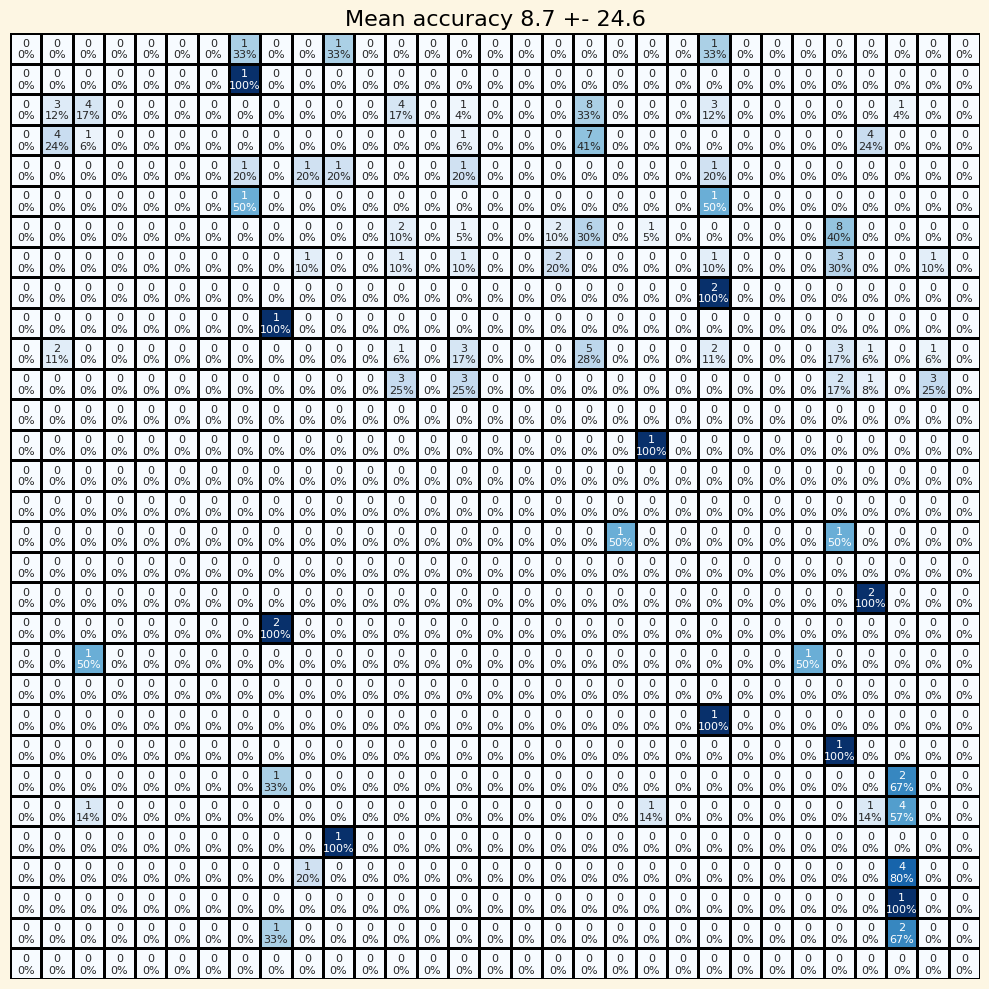

In [36]:
y_test_pred = clf.reconstruct(X_test.values)

create_and_plot_cm(y_test_pred, y_test)